In [1]:
import newutils
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('legend',fontsize = 14)

## Optimistic Bull Environment

In [2]:
import numpy as np
# Get the default financial and AC Model parameters for optimistic bull
financial_params1, ac_params1 = newutils.get_env_param(optimistic=True)

In [3]:
financial_params1

Annual Volatility:,6%,Bid-Ask Spread:,0.111
Daily Volatility:,0.4%,Daily Trading Volume:,"5,000,000"


In [4]:
ac_params1

Total Number of Shares for Agent1 to Sell:,"550,000",Fixed Cost of Selling per Share:,$0.056
Total Number of Shares for Agent2 to Sell:,"550,000",Trader's Risk Aversion for Agent 1:,1e-06
Starting Price per Share:,$50.00,Trader's Risk Aversion for Agent 2:,1e-06
Price Impact for Each 1% of Daily Volume Traded:,$2.222222222222222e-06,Permanent Impact Constant:,2.2222222222222222e-07
Number of Days to Sell All the Shares:,60,Single Step Variance:,0.036
Number of Trades:,60,Time Interval between trades:,1.0


## Cooperative

In [5]:
import numpy as np

import optimistic as sca
from ddpg_agent import Agent

from collections import deque

# Create simulation environment
env2 = sca.MarketEnvironment(optimistic=True)

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent1 = Agent(state_size=env2.observation_space_dimension(), action_size=env2.action_space_dimension(),random_seed = 1225)
agent2 = Agent(state_size=env2.observation_space_dimension(), action_size=env2.action_space_dimension(),random_seed = 108)
# Set the liquidation time
lqt = 60

# Set the number of trades
n_trades = 60

# Set trader's risk aversion
tr1 = 1e-06
tr2 = 1e-06

# Set the number of episodes to run the simulation
episodes = 3200
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_hist2 = np.array([])
shortfall_deque1 = deque(maxlen=100)
shortfall_deque2 = deque(maxlen=100)
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env2.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
    env2.start_transactions()

    for i in range(n_trades + 1):
      
        # Predict the best action for the current state. 
        cur_state1 = np.delete(cur_state,8)
        cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
        action1 = agent1.act(cur_state1, add_noise = True)
        action2 = agent2.act(cur_state2, add_noise = True)
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward1, reward2, done1, done2, info = env2.step(action1,action2,'cooperative')
        
        # current state, action, reward, new state are stored in the experience replay
        new_state1 = np.delete(new_state,8)
        new_state2 = np.delete(new_state,7)
        agent1.step(cur_state1, action1, reward1, new_state1, done1)
        agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
        cur_state = new_state

        if info.done1 and info.done2:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            
            shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
            shortfall_deque2.append(info.implementation_shortfall2)
            break
        
    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))
        shortfall_list.append([np.mean(shortfall_deque1),np.mean(shortfall_deque2)])
print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))
print('\nAverage Implementation Shortfall for Agent2: ${:,.2f} \n'.format(np.mean(shortfall_hist2)))

Episode [100/3200]	Average Shortfall for Agent1: $1,252,401.40
Episode [100/3200]	Average Shortfall for Agent2: $1,271,593.81
Episode [200/3200]	Average Shortfall for Agent1: $1,374,905.68
Episode [200/3200]	Average Shortfall for Agent2: $1,374,965.14
Episode [300/3200]	Average Shortfall for Agent1: $1,375,000.00
Episode [300/3200]	Average Shortfall for Agent2: $1,375,000.00
Episode [400/3200]	Average Shortfall for Agent1: $1,375,000.00
Episode [400/3200]	Average Shortfall for Agent2: $1,375,000.00
Episode [500/3200]	Average Shortfall for Agent1: $1,375,000.00
Episode [500/3200]	Average Shortfall for Agent2: $1,375,000.00
Episode [600/3200]	Average Shortfall for Agent1: $1,375,000.00
Episode [600/3200]	Average Shortfall for Agent2: $1,375,000.00
Episode [700/3200]	Average Shortfall for Agent1: $1,375,000.00
Episode [700/3200]	Average Shortfall for Agent2: $1,375,000.00
Episode [800/3200]	Average Shortfall for Agent1: $1,357,561.37
Episode [800/3200]	Average Shortfall for Agent2: $1,367

In [6]:
shortfall = np.array(shortfall_list)

In [8]:
np.save('optimistic-cooperative.npy',shortfall)

## Competitive

In [11]:
# Create simulation environment
env2 = sca.MarketEnvironment(optimistic=True)

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent1 = Agent(state_size=env2.observation_space_dimension(), action_size=env2.action_space_dimension(),random_seed = 1225)
agent2 = Agent(state_size=env2.observation_space_dimension(), action_size=env2.action_space_dimension(),random_seed = 108)
# Set the liquidation time
lqt = 60

# Set the number of trades
n_trades = 60

# Set trader's risk aversion
tr1 = 1e-06
tr2 = 1e-06

# Set the number of episodes to run the simulation
episodes = 3200
shortfall_list = []
shortfall_hist1 = np.array([])
shortfall_hist2 = np.array([])
shortfall_deque1 = deque(maxlen=100)
shortfall_deque2 = deque(maxlen=100)
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env2.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb1 = tr1,lamb2 = tr2)

    # set the environment to make transactions
    env2.start_transactions()

    for i in range(n_trades + 1):
      
        # Predict the best action for the current state. 
        cur_state1 = np.delete(cur_state,8)
        cur_state2 = np.delete(cur_state,7)
        #print(cur_state[5:])
        action1 = agent1.act(cur_state1, add_noise = True)
        action2 = agent2.act(cur_state2, add_noise = True)
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward1, reward2, done1, done2, info = env2.step(action1,action2,'competitive')
        
        # current state, action, reward, new state are stored in the experience replay
        new_state1 = np.delete(new_state,8)
        new_state2 = np.delete(new_state,7)
        agent1.step(cur_state1, action1, reward1, new_state1, done1)
        agent2.step(cur_state2, action2, reward2, new_state2, done2)
        # roll over new state
        cur_state = new_state

        if info.done1 and info.done2:
            shortfall_hist1 = np.append(shortfall_hist1, info.implementation_shortfall1)
            shortfall_deque1.append(info.implementation_shortfall1)
            
            shortfall_hist2 = np.append(shortfall_hist2, info.implementation_shortfall2)
            shortfall_deque2.append(info.implementation_shortfall2)
            break
        
    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent1: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque1)))        
        print('\rEpisode [{}/{}]\tAverage Shortfall for Agent2: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque2)))
        shortfall_list.append([np.mean(shortfall_deque1),np.mean(shortfall_deque2)])
print('\nAverage Implementation Shortfall for Agent1: ${:,.2f} \n'.format(np.mean(shortfall_hist1)))
print('\nAverage Implementation Shortfall for Agent2: ${:,.2f} \n'.format(np.mean(shortfall_hist2)))

Episode [100/3200]	Average Shortfall for Agent1: $1,258,196.23
Episode [100/3200]	Average Shortfall for Agent2: $1,274,209.69
Episode [200/3200]	Average Shortfall for Agent1: $1,374,922.85
Episode [200/3200]	Average Shortfall for Agent2: $1,374,789.23
Episode [300/3200]	Average Shortfall for Agent1: $1,374,999.19
Episode [300/3200]	Average Shortfall for Agent2: $1,374,997.65
Episode [400/3200]	Average Shortfall for Agent1: $1,269,592.04
Episode [400/3200]	Average Shortfall for Agent2: $1,296,873.75
Episode [500/3200]	Average Shortfall for Agent1: $437,688.96
Episode [500/3200]	Average Shortfall for Agent2: $427,184.86
Episode [600/3200]	Average Shortfall for Agent1: $370,071.20
Episode [600/3200]	Average Shortfall for Agent2: $373,736.93
Episode [700/3200]	Average Shortfall for Agent1: $337,273.34
Episode [700/3200]	Average Shortfall for Agent2: $333,766.25
Episode [800/3200]	Average Shortfall for Agent1: $341,720.93
Episode [800/3200]	Average Shortfall for Agent2: $338,454.99
Episode 

In [12]:
shortfall = np.array(shortfall_list)

In [13]:
np.save('optimistic-competitive.npy',shortfall)

In [14]:
A = np.load('./Results/1e-6_shortfall_list.npy')
B = np.load('optimistic-cooperative.npy')
C = np.load('optimistic-competitive.npy')

In [15]:
A_list = []
B_list = []
C_list = []
for i in range(len(B)):
    A_list.append(A[i])
    B_list.append(B[i].sum())
    C_list.append(C[i].sum())

In [22]:
df3 = pd.DataFrame()
df3['Independent'] = A_list
df3['Cooperative'] = B_list
df3['Competitive'] = C_list

/opt/homebrew/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
/opt/homebrew/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  """


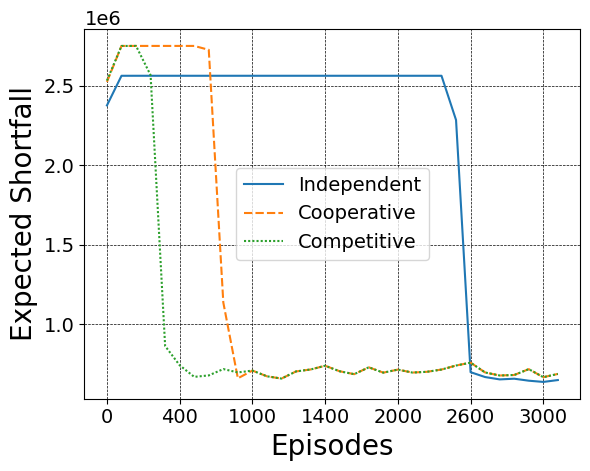

In [23]:
ax = sns.lineplot(data = df3)
ax.set_ylabel('Expected Shortfall',fontsize = 20)
ax.set_xlabel('Episodes',fontsize = 20)
ax.set_xticklabels([0,0,400,1000,1400,2000,2600,3000],fontsize = 14)
ax.grid(b=True, which='major', color='black', linewidth=0.5,linestyle = '--')